In [2]:
import numpy as np
import timeit

import torch
from matplotlib import pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table

from models.mixer import MLPMixer
from models.lora import LowRankLinearAdapter, adapt_model, merge_adapters
from utils.params import count_params, count_trainable_params

In [3]:
loaded_dict = torch.load("weights/mlp_mixer_imagenette.pth")

In [7]:
mixer = MLPMixer(
    image_size=(3, 128, 128),
    patch_size=8,
    hidden_dim=128,
    n_blocks=4,
    n_classes=10
)

mixer = mixer.load_state_dict(loaded_dict['state_dict'])

In [28]:
def print_dict(data: dict, title: str = "Table"):
    # assume data has keys: "columns" and "data"
    console = Console()
    table = Table(title=title)
    
    for column in data["columns"]:
        table.add_column(column, justify="left", style="cyan", no_wrap=True)
    
    for row in data["data"]:
        renderable_row = []
        for item in row:
            renderable_row.append(str(item))
        
        table.add_row(*renderable_row)
    
    console.print(table)

In [29]:
linear = torch.nn.Linear(28 * 28, 128)

params = count_params(linear)
trainable_params = count_trainable_params(linear)

lora_linear = LowRankLinearAdapter(linear, rank=2)

lora_params = count_params(lora_linear)
lora_trainable_params = count_trainable_params(lora_linear)

print_dict({
    "columns": ["Name", "Rank", "Total params", "Trainable params", "Fraction"],
    "data": [
        ("Linear", "-1", params, trainable_params, round(trainable_params / params, 2)),
        ("Linear(LoRA)", 2, lora_params, lora_trainable_params, round(lora_trainable_params / lora_params, 2))
    ]
}, title="Linear Layer Paramters")

                       Linear Layer Paramters                       
┏━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name         ┃ Rank ┃ Total params ┃ Trainable params ┃ Fraction ┃
┡━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Linear       │ -1   │ 100480       │ 100480           │ 1.0      │
│ Linear(LoRA) │ 2    │ 102304       │ 1952             │ 0.02     │
└──────────────┴──────┴──────────────┴──────────────────┴──────────┘

In [5]:
lora_linear = LowRankLinearAdapter(linear, rank=2)

# re-initialize B to random values rather than all zeros
lora_linear._lora._reinit_B(lambda r, d: torch.randn((r, d)))
print_dict_as_rich_table({
    "Total params": count_params(lora_linear),
    "Trainable params": count_trainable_params(lora_linear)
}, title="LoRA Linear Layer Paramters")

 LoRA Linear Layer Paramters 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Parameter        ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Total params     │ 102304 │
│ Trainable params │ 1952   │
└──────────────────┴────────┘

In [5]:
samaple_input = torch.randn(28 * 28).unsqueeze(0)

In [6]:
unmerged_output = lora_linear(samaple_input).log_softmax(dim=-1).exp().detach()

lora_linear.merge_weights()
merged_output = lora_linear(samaple_input).log_softmax(dim=-1).exp().detach()

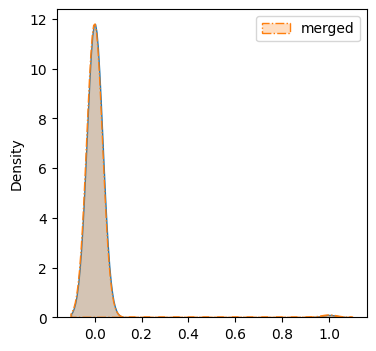

In [7]:
plt.figure(figsize=(4, 4))
sns.kdeplot(unmerged_output.flatten(), fill=True)
# plot with spaced out dashes, more spaced out than with "--"
sns.kdeplot(merged_output.flatten(), fill=True, label="merged", linestyle="-.")
plt.legend()

### Let's measure infrence time of merged vs unmerged

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
sample_input = torch.randn(1, 1, 28, 28).to(device)

In [10]:
mlp_mixer = MLPMixer(
    image_size=(1, 28, 28),
    patch_size=7,
    hidden_dim=128,
    n_blocks=1,
    n_classes=10
).to(device)

print_dict_as_rich_table({
    "Total params": count_params(mlp_mixer),
    "Trainable params": count_trainable_params(mlp_mixer)
}, title="LoRA Linear Layer Paramters")

LoRA Linear Layer Paramters 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter        ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Total params     │ 41770 │
│ Trainable params │ 41770 │
└──────────────────┴───────┘

In [11]:
from torch.utils.benchmark import Timer

In [12]:
timer = Timer(
    stmt="mlp_mixer(sample_input)",
    globals={"mlp_mixer": mlp_mixer, "sample_input": sample_input},
    label="Base MLP-Mixer Forward Pass"
)

times = timer.blocked_autorange(min_run_time=1.0)
times

Base MLP-Mixer Forward Pass
  Median: 684.57 us
  IQR:    6.74 us (682.14 to 688.88)
  1436 measurements, 1 runs per measurement, 1 thread

In [13]:
adapted_mixer = adapt_model(mlp_mixer, low_rank_adapter_type="lora", rank=4)
adapted_mixer = adapted_mixer.to(device)

print_dict_as_rich_table({
    "Total params": count_params(adapted_mixer),
    "Trainable params": count_trainable_params(adapted_mixer)
}, title="LoRA Linear Layer Paramters")

LoRA Linear Layer Paramters 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter        ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Total params     │ 45334 │
│ Trainable params │ 4502  │
└──────────────────┴───────┘

In [14]:
timer = Timer(
    stmt="adapted_mixer(sample_input)",
    globals={"adapted_mixer": adapted_mixer, "sample_input": sample_input},
    label="LoRA MLP-Mixer Forward Pass (Unmerged)"
)

times = timer.blocked_autorange(min_run_time=1.0)
times

LoRA MLP-Mixer Forward Pass (Unmerged)
  Median: 1.35 ms
  IQR:    0.10 ms (1.28 to 1.39)
  8 measurements, 100 runs per measurement, 1 thread

In [15]:
merge_adapters(adapted_mixer)

In [16]:
timer = Timer(
    stmt="adapted_mixer(sample_input)",
    globals={"adapted_mixer": adapted_mixer, "sample_input": sample_input},
    label="LoRA MLP-Mixer Forward Pass (Merged)"
)

times = timer.blocked_autorange(min_run_time=5)
times

LoRA MLP-Mixer Forward Pass (Merged)
  Median: 690.48 us
  IQR:    12.14 us (688.32 to 700.45)
  8 measurements, 1000 runs per measurement, 1 thread

In [ ]:
reference_times = timeit.repeat(lambda: mlp_mixer(sample_input), number=10000, repeat=20)

In [ ]:
lora_linear.unmerge_weights()
unmerged_times = timeit.repeat(lambda: lora_linear(samaple_input), number=10000, repeat=20)

In [ ]:
lora_linear.merge_weights()
merged_times = timeit.repeat(lambda: lora_linear(samaple_input), number=10000, repeat=20)

In [ ]:
import statistics

print(f"Unmerged time: {statistics.mean(unmerged_times): .4f}s (±{statistics.stdev(unmerged_times): .4f})")
print(f"Merged time: {statistics.mean(merged_times): .4f}s (±{statistics.stdev(merged_times): .4f})")